# Galaxies vs Quasars with Neural Networks

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 


3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the [multilayer perceptron classifier](sklearn.neural_network.MLPClassifier) implemented in scikit-learn. My solution uses the latter, but this is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

In [2]:
import numpy as np
import pandas as pd

from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold

import torch
import tensorflow as tf

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams['font.size'] = 15

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

In [3]:
data = pd.read_csv('galaxyquasar.csv')
print(data)
data_arr = np.array(data)

u = np.array(data_arr[:,0])
g = np.array(data_arr[:, 1])
r = np.array(data_arr[:, 2])
i = np.array(data_arr[:, 3])
z = np.array(data_arr[:, 4])
c = np.array(data_arr[:, 5]) #array for column class

#(u-g) color
ug = np.array(u-g)
#(g-r) color
gr = np.array(g-r)
#(r-i) color
ri = np.array(r-i)
#(i-z) color
iz = np.array(i-z)

#galaxy = 0, QSO = 1
labels = np.where(c =="QSO", 1, 0)
print(labels)

              u         g         r         i         z   class        z1  \
0      18.97213  18.53676  18.58280  18.34936  18.29215     QSO  0.522819   
1      19.24592  17.47646  16.47817  16.04472  15.68851  GALAXY  0.122846   
2      19.43536  17.70268  16.91565  16.58327  16.39128  GALAXY  0.000000   
3      19.31626  18.18312  17.39591  16.94549  16.65395  GALAXY  0.147435   
4      19.28828  19.11188  18.88937  18.80013  18.49183     QSO  2.011455   
...         ...       ...       ...       ...       ...     ...       ...   
49995  19.37295  18.12382  17.39886  16.98503  16.70585  GALAXY  0.113016   
49996  18.52021  16.88262  16.03280  15.56884  15.22454  GALAXY  0.085063   
49997  18.62718  17.30876  16.87371  16.62399  16.42296  GALAXY  0.054429   
49998  19.55140  18.27711  17.62101  17.21947  17.03347  GALAXY  0.112571   
49999  18.80772  17.75751  17.40500  17.21650  17.12295  GALAXY  0.043652   

           zerr  
0      0.000155  
1      0.000028  
2      0.000000  
3  

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

In [6]:
colors = ['ug', 'gr', 'ri', 'iz']

#split the dataset
x = np.array([ug, gr, ri, iz]).T

xtrain, xtest, ytrain, ytest = train_test_split(x, labels, test_size=0.7, random_state=1)

We plot the distribution of galaxies and QSO vs the differet coloros.

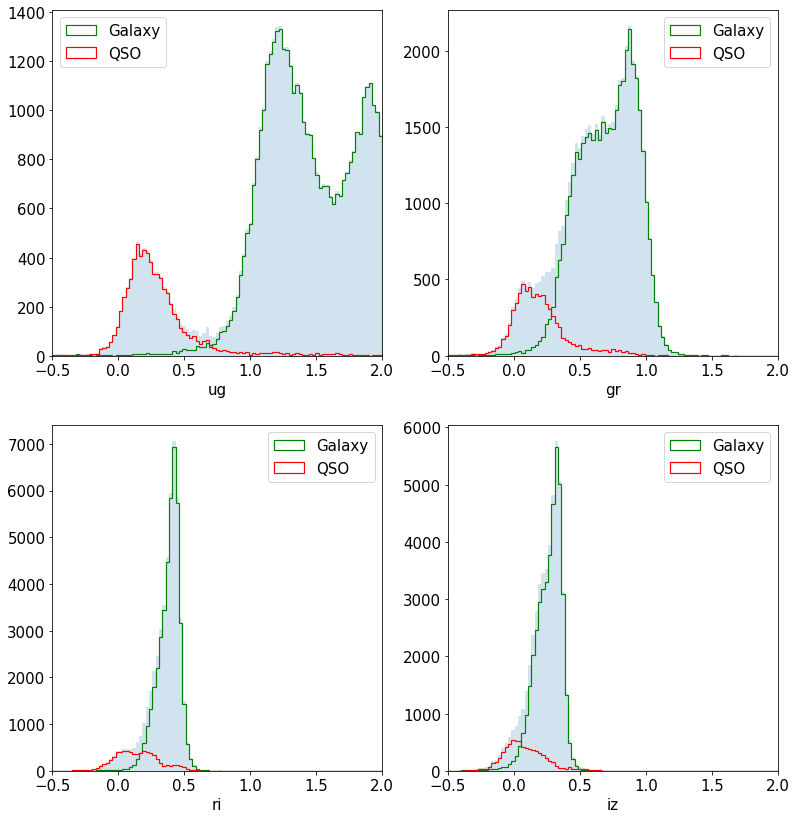

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(13, 14))
axs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
bins = np.linspace(-0.5, 2, 100)

for a, i in zip(axs, range(len(x))):
    a.hist(x[:, i], bins=bins, alpha=0.2)
    a.hist(x[:, i][labels==0], bins=bins, histtype='step', color='green', lw=1.2, label='Galaxy')
    a.hist(x[:, i][labels==1], bins=bins, histtype='step', color='red', lw=1.2, label='QSO')
    
    a.set_xlabel(colors[i])
    a.set_xlim(-0.5, 2)
    a.legend()
plt.show()

In [5]:
#cross-validation and definition of errors

def rms_error(x, y, classif):
    return np.sqrt(np.sum((y - classif.predict(x))**2))/len(y)

def errors_cv(x, y, classif):
    err_cval = []
    err_train = []
    
    for t_i, c_i in kf.split(x): #kf stands for KFolds
        x_train, x_cv = x[t_i], x[c_i]
        y_train, y_cv = y[t_i], y[c_i]
        
        classif.fit(x_train, y_train)
        err_train.append(rms_error(x_train, y_train, classif))
        err_cval.append(rms_error(x_cv, y_cv, classif))
        
    return np.median(err_train), np.median(err_cval)